In [1]:
import pandas as pd
import json
import requests
import datetime as dt
from datetime import date, timedelta, datetime
from tqdm.notebook import tqdm
import time
import osmnx as ox
import geopandas as gpd
import fiona
import shapely.geometry as geom

ox.config(log_console=True, use_cache=True)

# Function to make the start dates list 
def days(start, end, step=timedelta(days=90)):
    curr = start
    while curr <= end:
        yield curr
        curr += step

c:\Users\Ibrahem.Alsalamh\Anaconda3\envs\geoenv\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


C:\Users\Ibrahem.Alsalamh\AppData\Local\Temp\ipykernel_17652\409818125.py:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  osm_network_joined.to_file(r'C:\Users\Ibrahem.Alsalamh\OneDrive - Arup\Freiburg smart city\traffic data\freiburg_traffic_data\osm_network_joined.shp')


<AxesSubplot:>

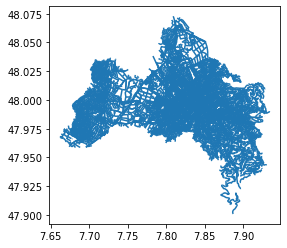

In [5]:
# Run only if you want to update the osm data 
# Download, read, update and save the newesr OSM shape file for Freiburg 
# place='Freiburg im Breisgau'
# path_shp_roads=r'C:\Users\Ibrahem.Alsalamh\OneDrive - Arup\Freiburg smart city\traffic data\shp\city_roads'
# osm_network = ox.graph_from_place(place, network_type='all')
# ox.plot_graph(osm_network,show=False,close=False,bgcolor="#333333",edge_color="w", edge_linewidth=0.3,node_size=0.01)
# ox.save_graph_shapefile(osm_network, filepath=path_shp_roads)
# osm_network=gpd.read_file(path_shp_roads)

# add the city district 
path_shp_district=r'C:\Users\Ibrahem.Alsalamh\OneDrive - Arup\Freiburg smart city\traffic data\freiburg_traffic_data\shp\city_districts'
osm_city_district=gpd.read_file(path_shp_district)
osm_city_district = osm_city_district.to_crs('EPSG:4326')
path_shp_roads=r'C:\Users\Ibrahem.Alsalamh\OneDrive - Arup\Freiburg smart city\traffic data\freiburg_traffic_data\shp\osm_data\edited\splitted_by_inrix'
osm_network=gpd.read_file(path_shp_roads)

osm_network_joined=gpd.sjoin(osm_network,osm_city_district, how='inner')
osm_network_joined.drop('index_right', inplace=True ,axis=1)
osm_network_joined.to_file("osm_network_joined.shp")
osm_network_joined=osm_network_joined[['osm_id','oneway','fclass','name_left','name_right','geometry']].rename(columns={'name_left':'road_name','name_right':'city_district'})
#osm_network_joined=osm_network_joined.add_suffix('_osm')
osm_network_joined = gpd.GeoDataFrame(osm_network_joined, crs='EPSG:4326', geometry=osm_network_joined.geometry)
osm_network_joined.to_file(r'C:\Users\Ibrahem.Alsalamh\OneDrive - Arup\Freiburg smart city\traffic data\freiburg_traffic_data\osm_network_joined.shp')
osm_network_joined.plot()

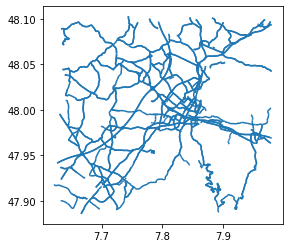

In [ ]:
# Get Inrix live data (1min), adjust them and join them with OSM
url = 'http://inrixfreiburg.traffgoroad.com/inrix_freiburg.json'
username = 'arup'
password = 'RJXvRaFMk:'

response=requests.get(url, auth=(username, password))
response_json=response.json()

data_segment=pd.DataFrame()

for result in response_json['result']['segmentSpeeds']:
    segments=result['segments']
    data=pd.DataFrame(segments)
    data['date']=datetime.today().strftime('%Y-%m-%d')
    data['time']=dt.datetime.now().strftime('%H:%M')
    data_segment=pd.concat([data_segment,data])
data_segment.to_csv(r'C:\Users\Ibrahem.Alsalamh\OneDrive - Arup\Freiburg smart city\traffic data\inrix_data_new.csv')

path_shp_inrix=r'C:\Users\Ibrahem.Alsalamh\Downloads\Germany_Baden_Wurttemberg_shapefile'
inrix_data_csv=pd.read_csv(r'C:\Users\Ibrahem.Alsalamh\OneDrive - Arup\Freiburg smart city\traffic data\inrix_data_new.csv')
inrix_data_shp=gpd.read_file(path_shp_inrix)
inrix_data_shp=inrix_data_shp[['XDSegID','RoadNumber','RoadName','PostalCode','geometry']]
inrix_data_shp=pd.merge(inrix_data_csv, inrix_data_shp,left_on='code',right_on='XDSegID',how='left')
inrix_data_shp=inrix_data_shp.add_suffix('_inrix')
inrix_data_shp = gpd.GeoDataFrame(inrix_data_shp, crs='EPSG:4326', geometry=inrix_data_shp.geometry_inrix)
inrix_data_shp.drop(['XDSegID_inrix','geometry_inrix'],inplace=True,axis=1)
inrix_data_shp.plot()
inrix_osm_data_shp=gpd.sjoin(osm_network_joined,inrix_data_shp, how='left')
inrix_osm_data_shp.drop('index_right',inplace=True,axis=1)

In [ ]:
# Download Telramm historcal data till today 

# Create the date list
starting_date=date(2020, 1, 1)
date_list=list(days(starting_date, dt.date.today()))

# POSTtraffic snapshot Telraam to get a list of segment ids
data_segment=pd.DataFrame()
data_list2=date_list.copy()
data_list2.append(dt.date.today())
for start_date in tqdm(data_list2):
  time.sleep(2)
  url = "https://telraam-api.net/v1/reports/traffic_snapshot"
  payload = "{\r\n    \"time\":\"" +str(start_date)+ " 00:00:00Z\",\r\n    \"contents\":\"full\",\r\n    \"area\":\"7.8359048,47.9963918,10\"\r\n}\r\n"
  headers = {'X-Api-Key': '9bDufSS8AE2NAOT2R5YtR9vutyukJlZh6ZQyhTnQ'}
  response = requests.request("POST", url, headers=headers, data=payload,)
  response_json=response.json()
  response_json=pd.json_normalize(response_json['features'])  
  data_segment=pd.concat([data_segment,response_json])

segment_ids_list=data_segment['properties.segment_id'].unique().tolist()
geometry_data=data_segment[['properties.segment_id','geometry.coordinates']].drop_duplicates(subset='properties.segment_id')

# POSTtraffic Telraam to get historical data
data_repot=pd.DataFrame()
for segment_id in tqdm(segment_ids_list):
    for start_date in tqdm(date_list):
        time.sleep(2)
        end_date=start_date+ dt.timedelta(days=89)
        if end_date <= dt.date.today():
            payload = "{\r\n  \"level\": \"segments\",\r\n  \"format\": \"per-hour\",\r\n  \"id\": \""+str(segment_id)+"\",\r\n  \"time_start\": \"" +str(start_date)+ " 00:00:00Z\",\r\n  \"time_end\": \""+ str(end_date)+ " 23:00:00Z\"\r\n}"
            url = "https://telraam-api.net/v1/reports/traffic"
            headers = {'X-Api-Key': '9bDufSS8AE2NAOT2R5YtR9vutyukJlZh6ZQyhTnQ'}
            response = requests.request("POST", url, headers=headers, data=payload)
            response_json=response.json()

            for result in response_json['report']:
                data=pd.DataFrame([result])
                data_repot=pd.concat([data_repot,data])

    start_date = end_date+dt.timedelta(days=-89)            
    end_date = dt.date.today()
    payload = "{\r\n  \"level\": \"segments\",\r\n  \"format\": \"per-hour\",\r\n  \"id\": \""+str(segment_id)+"\",\r\n  \"time_start\": \"" +str(start_date)+ " 00:00:00Z\",\r\n  \"time_end\": \""+ str(end_date)+ " 23:00:00Z\"\r\n}"
    url = "https://telraam-api.net/v1/reports/traffic"
    headers = {'X-Api-Key': '9bDufSS8AE2NAOT2R5YtR9vutyukJlZh6ZQyhTnQ'}
    response = requests.request("POST", url, headers=headers, data=payload)
    response_json=response.json()

    for result in response_json['report']:
        data=pd.DataFrame([result])
        data_repot=pd.concat([data_repot,data])

# Add the type of day
data_repot['weekday']=data_repot['date'].str.split('T').str[0]
data_repot['weekday'] =  pd.to_datetime(data_repot['weekday'], format='%Y-%m-%d')
data_repot['weekday'] = data_repot['weekday'].dt.weekday.apply(lambda x: 'Weekday' if x < 5 else 'Weekend')   
# Bring the location data
data_repot=pd.merge(left=data_repot,right=geometry_data,left_on='segment_id', right_on='properties.segment_id')
data_repot.drop('properties.segment_id',inplace=True, axis=1)
data_repot.to_csv(r'C:\Users\Ibrahem.Alsalamh\OneDrive - Arup\Freiburg smart city\traffic data\telraam_data_freiburg_complete.csv')

# Read and transfer Telraam into shapefile and then intersect them with the osm data  
telraam_data_shp=pd.read_csv(r'C:\Users\Ibrahem.Alsalamh\OneDrive - Arup\Freiburg smart city\traffic data\telraam_data_freiburg_complete.csv',index_col=0)
telraam_data_shp['geometry.coordinates_start']= telraam_data_shp['geometry.coordinates'].str.split(']').str[0].str.strip('[')
telraam_data_shp[['start_x','start_y']] = telraam_data_shp['geometry.coordinates_start'].str.split(',',expand=True).astype(float)
telraam_data_shp['geometry.coordinates_end']= telraam_data_shp['geometry.coordinates'].str.split('[').str[-1].str.strip(']')
telraam_data_shp[['end_x','end_y']] = telraam_data_shp['geometry.coordinates_end'].str.split(',',expand=True).astype(float)
telraam_data_shp['geometry'] = telraam_data_shp.apply(lambda x: geom.LineString([(x['start_x'], x['start_y']) , (x['end_x'], x['end_y'])]), axis = 1)
telraam_data_shp['midpoint'] = telraam_data_shp.apply(lambda row: row['geometry'].centroid, axis=1) #Find centroid
telraam_data_shp=telraam_data_shp.add_suffix('_telraam')
telraam_data_shp = gpd.GeoDataFrame(telraam_data_shp, crs='EPSG:4326', geometry=telraam_data_shp.midpoint_telraam)
telraam_data_shp.drop(['geometry.coordinates_telraam','geometry.coordinates_start_telraam','geometry.coordinates_end_telraam','start_x_telraam','start_y_telraam','end_x_telraam','end_y_telraam','midpoint_telraam'],inplace=True, axis=1)
telraam_data_shp.plot()


In [ ]:
telraam_data_summary=telraam_data_shp.copy()
telraam_data_summary['year_telraam'] = pd.DatetimeIndex(telraam_data_summary['date_telraam']).year
telraam_data_summary['month_telraam'] = pd.DatetimeIndex(telraam_data_summary['date_telraam']).month
telraam_data_summary['day_telraam'] = pd.DatetimeIndex(telraam_data_summary['date_telraam']).day

telraam_data_summary=telraam_data_summary.loc[(telraam_data_summary[['heavy_telraam','car_telraam','bike_telraam','pedestrian_telraam']] != 0).any(axis=1)]
telraam_data_summary=telraam_data_summary.groupby(['segment_id_telraam','year_telraam','month_telraam','direction_telraam']).agg({'uptime_telraam':'mean','heavy_telraam':'mean',
'car_telraam':'mean','bike_telraam':'mean','pedestrian_telraam':'mean','v85_telraam':'mean','day_telraam': pd.Series.nunique}).reset_index()
telraam_data_summary=telraam_data_summary.groupby(['segment_id_telraam','year_telraam','direction_telraam']).agg({'uptime_telraam':'mean','heavy_telraam':'mean',
'car_telraam':'mean','bike_telraam':'mean','pedestrian_telraam':'mean','v85_telraam':'mean','day_telraam': 'sum'}).rename(columns={'day_telraam': 'count_days_telraam'}).reset_index()

telraam_data_summary=telraam_data_summary.loc[telraam_data_summary.reset_index().groupby(['segment_id_telraam','direction_telraam'])['count_days_telraam'].idxmax()]
telraam_data_summary=telraam_data_summary.add_suffix('_ref')
telraam_data_summary.to_csv('telraam_data_summary_ref.csv')

In [ ]:
# Concat the OSM and inrix data to the Telraam data and save it in shp, Geojson and csv format
telraam_data_joined=gpd.sjoin_nearest(telraam_data_shp, inrix_osm_data_shp, how='left')
telraam_data_joined.drop([ 'geometry','geometry_telraam','index_right','Unnamed: 0_inrix'],inplace=True,axis=1)
cols_at_end = ['geometry_osm']
telraam_data_joined = telraam_data_joined[[c for c in telraam_data_joined if c not in cols_at_end] + [c for c in cols_at_end if c in telraam_data_joined]]
telraam_data_joined = gpd.GeoDataFrame(telraam_data_joined, crs='EPSG:4326', geometry=telraam_data_joined.geometry_osm)
telraam_data_joined.drop('geometry_osm', inplace=True,axis=1)
telraam_data_joined.to_file(r'C:\Users\Ibrahem.Alsalamh\OneDrive - Arup\Freiburg smart city\traffic data\final_output\telraam_data_joined.shp')
telraam_data_joined.to_file(r'C:\Users\Ibrahem.Alsalamh\OneDrive - Arup\Freiburg smart city\traffic data\final_output\telraam_data_joined.geojson',driver="GeoJSON")
telraam_data_joined.drop('geometry',axis=1).to_csv(r'C:\Users\Ibrahem.Alsalamh\OneDrive - Arup\Freiburg smart city\traffic data\final_output\telraam_data_joined.csv')

c:\Users\Ibrahem.Alsalamh\Anaconda3\envs\geoenv\lib\site-packages\geopandas\array.py:340: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
C:\Users\Ibrahem.Alsalamh\AppData\Local\Temp\ipykernel_16436\2828197880.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  telraam_data_joined.to_file(r'C:\Users\Ibrahem.Alsalamh\OneDrive - Arup\Freiburg smart city\traffic data\final_output\telraam_data_joined.shp')
